In [1]:
import numpy as np
from scipy.io import loadmat
import albumentations
from transformers import SamProcessor, SamModel

In [66]:
#!pip install -q monai

In [2]:
base_model_name = "facebook/sam-vit-base"
processor = SamProcessor.from_pretrained(base_model_name)
model = SamModel.from_pretrained(base_model_name)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [3]:
for (key,item) in model.__dict__["_modules"].items():
    print(key)

shared_image_embedding
vision_encoder
prompt_encoder
mask_decoder


In [5]:
model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [6]:
import copy
mask_decoders=[copy.deepcopy(model.mask_decoder) for i in range(14)]

In [7]:
mask_decoders[0].train()

SamMaskDecoder(
  (iou_token): Embedding(1, 256)
  (mask_tokens): Embedding(4, 256)
  (transformer): SamTwoWayTransformer(
    (layers): ModuleList(
      (0-1): 2 x SamTwoWayAttentionBlock(
        (self_attn): SamAttention(
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (layer_norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (cross_attn_token_to_image): SamAttention(
          (q_proj): Linear(in_features=256, out_features=128, bias=True)
          (k_proj): Linear(in_features=256, out_features=128, bias=True)
          (v_proj): Linear(in_features=256, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=256, bias=True)
        )
        (layer_norm2): LayerNorm((256,

In [48]:
def transform_image(img):
    img = img.transpose(2,1,0)
    image = np.expand_dims(img, axis=3)
    image = np.repeat(255 - image, 3, axis=3)
    return image

In [3]:
mat_dme =[]
for i in range(10):
    number = str(i+1).zfill(2)
    mat_dme.append("..\data\DME\Kaggle\Subject_"+number+".mat")

In [172]:
images = loadmat(mat_dme[0])['images']
masks = loadmat(mat_dme[0])['manualFluid1']

(496, 768, 61)

In [182]:
def get_valid_idx(mask):
    idx = []
    for i in range(0,61):
        temp = mask[:,:,i]
        if np.nansum(temp) != 0:
            idx.append(i)
    return idx

In [183]:
idx = get_valid_idx(masks)
masks = masks[:,:, idx]
images = images[:,:,idx]

(496, 768, 9)

In [187]:
images = transform_image(images)
masks = np.where(masks ==0, 0,1).transpose(2,1,0)

In [188]:
from datasets import Dataset, Image

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                 "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [189]:
dataset = create_dataset(images=images, labels=masks)

C:\Users\phili\anaconda3\envs\DILab\Lib\site-packages\datasets\features\image.py:332: UserWarning: Downcasting array dtype int32 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


In [190]:
transform = albumentations.Compose([albumentations.Resize(256, 256),])

In [191]:
def transforms(examples):
    transformed_images, transformed_masks = [], []
    for image, seg_mask in zip(examples["image"], examples["label"]): 
        image, seg_mask = np.array(image), np.array(seg_mask)   
        transformed = transform(image=image, mask=seg_mask)    
        transformed_images.append(transformed["image"])    
        transformed_masks.append(transformed["mask"])   
    examples["pixel_values"] = transformed_images    
    examples["label"] = transformed_masks
    return examples

In [192]:
dataset.set_transform(transforms)

In [200]:
index = 2

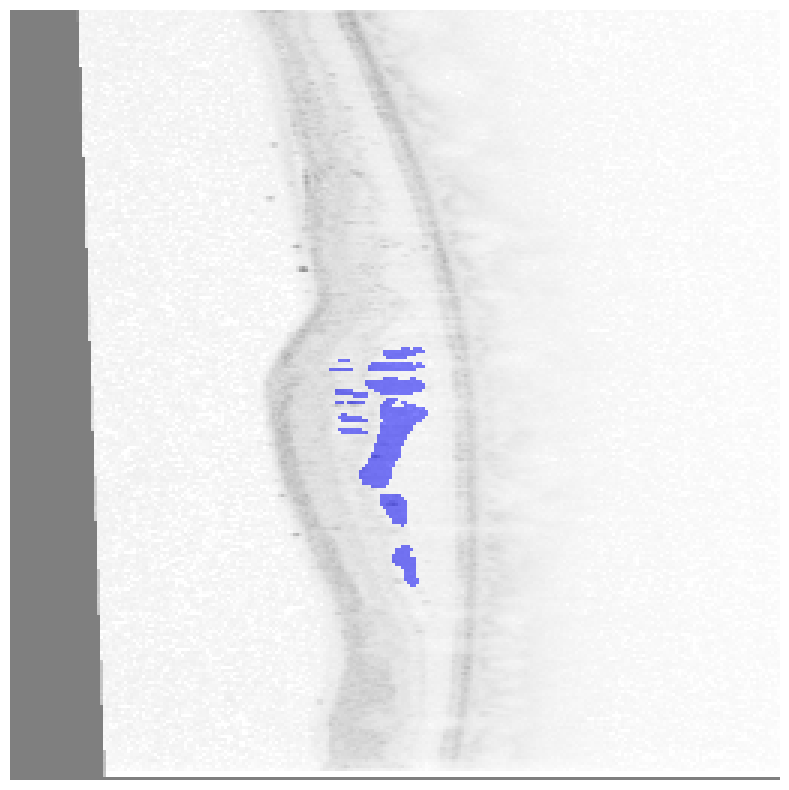

In [203]:
import matplotlib.pyplot as plt

def visualize_seg_mask(image: np.ndarray, mask: np.ndarray):
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    color_seg[mask == 0, :] = [255,255,255]
    #color_seg[mask == 1, :] = [255,255,255]
    color_seg[mask == 1, :] = [255,0,0]
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


visualize_seg_mask(
    np.array(dataset[index]["pixel_values"]),
    np.array(dataset[index]["label"])
)

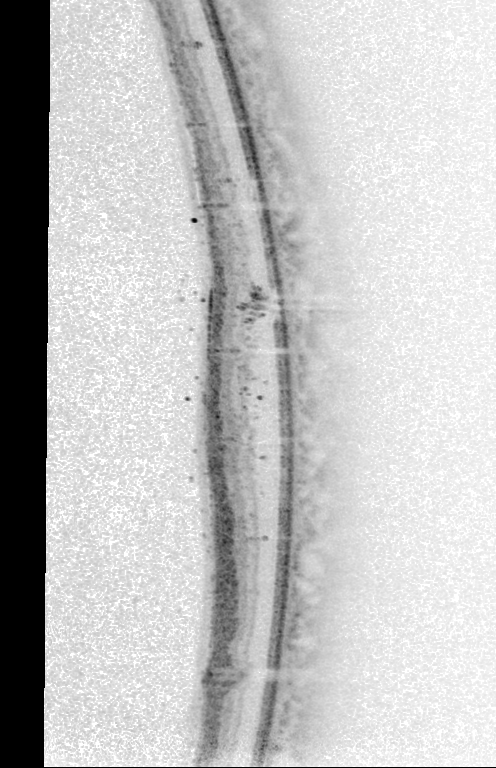

In [199]:
example = dataset[0]
image = example["pixel_values"]
example["image"]

(-0.5, 255.5, 255.5, -0.5)

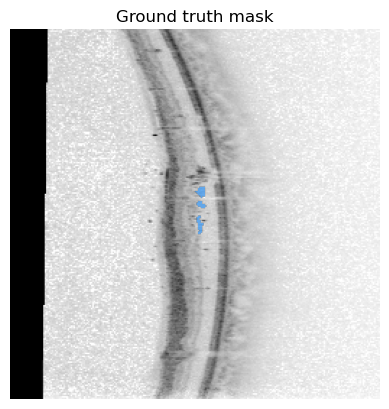

In [198]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [204]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [205]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["pixel_values"]
        ground_truth_mask = np.array(item["label"])
        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)
        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask
        return inputs

In [206]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [207]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [208]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [209]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [211]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [212]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


EPOCH: 0
Mean loss: 0.5957211971282959


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


EPOCH: 1
Mean loss: 0.5170679271221161


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 2
Mean loss: 0.4277698963880539


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 3
Mean loss: 0.4401578724384308


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 4
Mean loss: 0.39761677384376526


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 5
Mean loss: 0.4304373264312744


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 6
Mean loss: 0.4269269645214081


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 7
Mean loss: 0.3863305330276489


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 8
Mean loss: 0.3618155658245087


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 9
Mean loss: 0.3632333755493164


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 10
Mean loss: 0.3510737091302872


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 11
Mean loss: 0.3573524743318558


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 12
Mean loss: 0.3082452863454819


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 13
Mean loss: 0.3387645214796066


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 14
Mean loss: 0.32319153249263766


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 15
Mean loss: 0.29509687423706055


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 16
Mean loss: 0.32315943837165834


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 17
Mean loss: 0.2838295340538025


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 18
Mean loss: 0.28971711695194247


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 19
Mean loss: 0.26545041501522065


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 20
Mean loss: 0.30578595995903013


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 21
Mean loss: 0.2875243067741394


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 22
Mean loss: 0.2792376458644867


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 23
Mean loss: 0.26139731854200365


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 24
Mean loss: 0.2874897807836533


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 25
Mean loss: 0.3001240730285645


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 26
Mean loss: 0.24565353989601135


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 27
Mean loss: 0.26604480743408204


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 28
Mean loss: 0.24106780886650087


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 29
Mean loss: 0.24831632077693938


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 30
Mean loss: 0.2594686210155487


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 31
Mean loss: 0.23692152500152588


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 32
Mean loss: 0.2672158807516098


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 33
Mean loss: 0.2703543335199356


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 34
Mean loss: 0.3002053707838058


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 35
Mean loss: 0.23963714838027955


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 36
Mean loss: 0.26734019815921783


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 37
Mean loss: 0.23400338292121886


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 38
Mean loss: 0.26012192368507386


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 39
Mean loss: 0.24951376020908356


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 40
Mean loss: 0.2048937350511551


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 41
Mean loss: 0.21501947343349456


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 42
Mean loss: 0.26403572857379914


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 43
Mean loss: 0.22316785752773285


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 44
Mean loss: 0.25365395545959474


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 45
Mean loss: 0.2885806500911713


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 46
Mean loss: 0.2580685555934906


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


EPOCH: 47
Mean loss: 0.24471085369586945


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 48
Mean loss: 0.2680533766746521


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 49
Mean loss: 0.23154033720493317


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 50
Mean loss: 0.21048357784748079


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


EPOCH: 51
Mean loss: 0.22010932564735414


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 52
Mean loss: 0.23139208257198335


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


EPOCH: 53
Mean loss: 0.22632232904434205


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 54
Mean loss: 0.19723574221134185


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 55
Mean loss: 0.21201910674571992


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


EPOCH: 56
Mean loss: 0.19789002239704132


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


EPOCH: 57
Mean loss: 0.19595833122730255


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


EPOCH: 58
Mean loss: 0.22522682845592498


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 59
Mean loss: 0.21409529447555542


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 60
Mean loss: 0.19426751434803008


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 61
Mean loss: 0.1958255425095558


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 62
Mean loss: 0.20401081144809724


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 63
Mean loss: 0.20256611704826355


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 64
Mean loss: 0.18956554234027861


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 65
Mean loss: 0.20357425212860109


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 66
Mean loss: 0.18670764267444612


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 67
Mean loss: 0.17608389258384705


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 68
Mean loss: 0.18711838573217393


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 69
Mean loss: 0.1801126480102539


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 70
Mean loss: 0.19657361805438994


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 71
Mean loss: 0.1888476550579071


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


EPOCH: 72
Mean loss: 0.17610966861248017


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 73
Mean loss: 0.19265112280845642


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 74
Mean loss: 0.18025812804698943


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 75
Mean loss: 0.183395054936409


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 76
Mean loss: 0.2024953246116638


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 77
Mean loss: 0.18888189792633056


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 78
Mean loss: 0.1802372694015503


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 79
Mean loss: 0.1655210793018341


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 80
Mean loss: 0.17801052182912827


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 81
Mean loss: 0.15835247188806534


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 82
Mean loss: 0.18840187638998032


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 83
Mean loss: 0.1862410306930542


100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


EPOCH: 84
Mean loss: 0.1683465361595154


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


EPOCH: 85
Mean loss: 0.21036239266395568


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


EPOCH: 86
Mean loss: 0.15532283186912538


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 87
Mean loss: 0.1784943163394928


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 88
Mean loss: 0.18472302854061126


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 89
Mean loss: 0.1649618238210678


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 90
Mean loss: 0.1653338611125946


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


EPOCH: 91
Mean loss: 0.17341192364692687


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


EPOCH: 92
Mean loss: 0.17138446122407913


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 93
Mean loss: 0.167437145113945


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 94
Mean loss: 0.15983631014823912


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


EPOCH: 95
Mean loss: 0.17446935176849365


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


EPOCH: 96
Mean loss: 0.1687586635351181


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 97
Mean loss: 0.16823576986789704


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


EPOCH: 98
Mean loss: 0.1725519448518753


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

EPOCH: 99
Mean loss: 0.1469593957066536


In [219]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 3

# load image
image = dataset[idx]["pixel_values"]
image

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [243, 243, 243],
        [251, 251, 251],
        [239, 239, 239]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [244, 244, 244],
        [246, 246, 246],
        [238, 238, 238]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [240, 240, 240],
        [239, 239, 239],
        [237, 237, 237]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [238, 238, 238],
        [240, 240, 240],
        [241, 241, 241]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [244, 244, 244],
        [255, 255, 255],
        [252, 252, 252]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [241, 241, 241],
        [252, 252, 252],
        [255, 255, 255]]

In [220]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [221]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

In [222]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

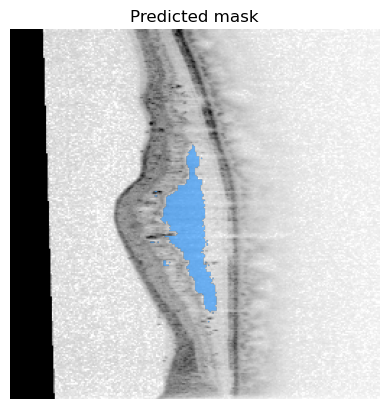

In [223]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

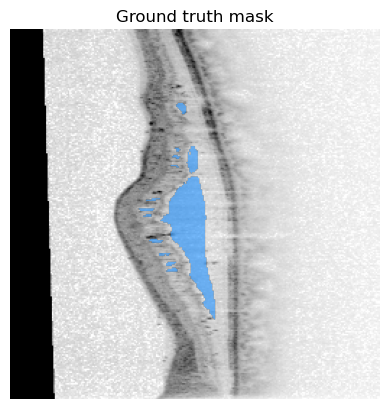

In [224]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [230]:
model_sam = SamModel.from_pretrained("facebook/sam-vit-base")
model_sam.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [227]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [231]:
model_sam.eval()
with torch.no_grad():
    outputs = model_sam(**inputs, multimask_output=False)

In [232]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

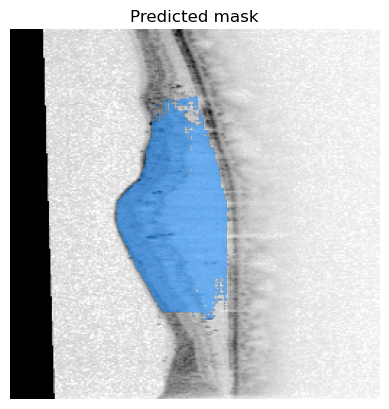

In [233]:
fig, axes = plt.subplots()
axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [234]:
processor_medsam = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
model_medsam = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)

In [235]:
model_sam.eval()
with torch.no_grad():
    outputs = model_medsam(**inputs, multimask_output=False)

In [236]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

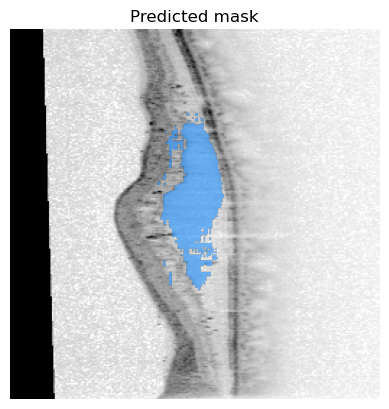

In [237]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")